In [11]:
from __future__ import annotations

import numpy as np
import pandas as pd

from typing import *

In [2]:
from nepal.datasets import NYTimes
from nepal.ml.preprocess import Cases

df: pd.DataFrame = Cases(NYTimes()).preprocessed()

In [9]:
from nepal.ml.forecaster import BaseForecaster
from nepal.ml.splitter import Splitter

def cross_validate(
        forecaster: BaseForecaster, *, splitter: Splitter, y: pd.DataFrame, X: Optional[Iterable[pd.DataFrame]] = None
) -> Sequence[float]:
    scores: List[float] = []
    for df_train, df_test in splitter.train_test_splits(y=y):
        model = forecaster.fit(y=df_train, X=X)
        df_pred = model.forecast(fh=splitter.fh, y=df_train, X=X)

        with warnings.catch_warnings():
            warnings.simplefilter(action="ignore", category=FutureWarning)
            score: float = mape(y_true=df_test, y_pred=df_pred, symmetric=True)
            scores.append(score)

    return scores

In [10]:
import lightgbm as lgb
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

from nepal.ml.forecaster import LGBMForecaster
from nepal.ml.splitter import Splitter

fh = ForecastingHorizon(list(range(1, 15)))
cv = SlidingWindowSplitter(fh=fh, window_length=60, step_length=60)
splitter: Splitter = Splitter(cv)

# Create regressor with default parameters
forecaster = LGBMForecaster(lgb.LGBMRegressor(), lag=12)

scores: Sequence[float] = cross_validate(forecaster, splitter=splitter, y=df[["new_cases"]])
print(np.mean(scores))

Train/Test split:   0%|          | 0/13 [00:00<?, ?it/s]

1.1977057034677403


<AxesSubplot:>

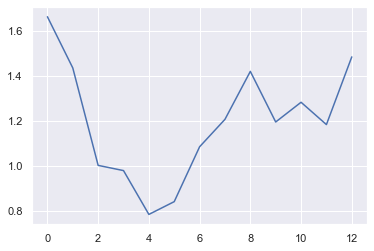

In [12]:
import seaborn as sns

sns.set(style="darkgrid")
sns.lineplot(data=scores)